<a href="https://colab.research.google.com/github/Shra1-25/ML4SCI/blob/main/ParticleImagesChallenge/ParticleImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackathon - Particle Images
## Problem Statement 
*   One of the important aspects of searches for new physics at the Large Hadron Collider (LHC) involves the classification of various High-Energy Particles in collision events
*   The goal of this challenge is to develop a model which classifies electron and photon electromagnetic showers as accurately as possible based on the detector images provided in the dataset below (one pixel = one channel of the detector)
*   The preferred metric for evaluating the model is ROC curve (Receiver Operating Characteristic curve) and the AUC (Area Under the ROC Curve) score.
*   Although we are using Keras Framework in this sample notebook, you are free to choose Machine Learning / Deep Learning Framework of your choice. 



## Create the appropriate project folder 

In [1]:
mkdir Particle_Images

In [2]:
cd Particle_Images

/home/n/Documents/Random/Coding/ML4SCI/ParticleImagesChallenge/Particle_Images


In [3]:
mkdir data/

# Download the Dataset

In [4]:
#!/bin/bash
!wget https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download -O data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
!wget https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download -O data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

--2020-10-26 23:30:45--  https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 188.184.97.72, 128.142.32.26, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87010508 (83M) [application/octet-stream]
Saving to: ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’

data/SingleElectron 100%[===================>]  82.98M  10.6MB/s    in 8.9s    

Last-modified header invalid -- time-stamp ignored.
2020-10-26 23:30:56 (9.33 MB/s) - ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’ saved [87010508/87010508]

--2020-10-26 23:30:56--  https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.32.38, 128.142.32.26, 188.184.97.72, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.32.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79876391 (

# Import modules

In [58]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import h5py
import pandas as pd
from keras.models import Sequential
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau
import seaborn as sns

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

# Keras Model Parameters

In [7]:
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 64       # Training batch size
train_size  = 1024     # Training size
valid_size  = 1024     # Validation size
test_size   = 1024     # Test size
epochs      = 20       # Number of epochs
doGPU       = True    # Use GPU

## It is recommended to use GPU for training and inference if possible.

In [8]:
if doGPU:
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    set_session(tf.Session(config=config))

# Load Image Data
### Two classes of particles: electrons and photons
### 32x32 matrices (two channels - hit energy and time) for the two classes of particles electrons and photons impinging on a calorimeter (one calorimetric cell = one pixel).
#### Please note that although timing channel is provided, it may not necessarily help the performance of the model.

In [11]:
img_rows, img_cols, nb_channels = 32, 32, 2        
input_dir = 'Particle_Images/data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']
# 0 is photon 1 is electron

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

# Configure Training / Validation / Test Sets

In [12]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

# Plot sample of training images
### Please note that although timing channel is provided, it may not necessarily help the performance of the model.

In [13]:
print(np.nanmean(np.max(X_train[:train_size,:,:,0])), np.nanmean(np.max(X_train[train_size:,:,:,0])))

1.4036604 1.2166635


In [14]:
plt.figure(1)

# 100 looks like some kind of particle
plt.subplot(221)
plt.imshow(X_train[sample_number,:,:,0])
plt.title("Channel 0: Energy")  # Energy
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[sample_number,:,:,1])
plt.title("Channel 1: Time")  # Time
plt.grid(True)


plt.savefig(f'/home/n/Documents/Random/Coding/ML4SCI/ParticleImagesChallenge/images/test_images/1/{sample_number}')

NameError: name 'sample_number' is not defined

# Define CNN Model
## This is a sample model. You can experiment with the model and try various architectures and other models to achieve the highest possible performance.  

## Train the Model
### You may further optimize the model, tune hyper-parameters, etc. accordingly to achieve the best performance possible.

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

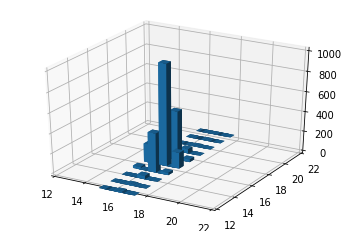

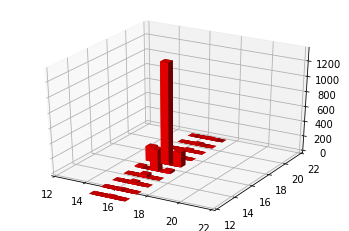

In [82]:
from mpl_toolkits.mplot3d import Axes3D

# noise threshold 
thresh = .1

# time or energy
te = 0

# bins 
bins = 0

# 0
idxs = np.where(X_train[train_size:, :, :, te] > thresh)
hist_0, xedges, yedges = np.histogram2d(idxs[1], idxs[2])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', )

xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

ax.set_xlim3d(12, 22)
ax.set_ylim3d(12, 22)

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist_0.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

# 1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', )

idxs = np.where(X_train[:train_size, :, :, te] > thresh)
hist_1, xedges, yedges = np.histogram2d(idxs[1], idxs[2])

xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist_1.ravel()

ax.set_xlim3d(12, 22)
ax.set_ylim3d(12, 22)
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color='r', label='electrons')

plt.show()

In [37]:
dist_0 = [[idx for i in range(int(x))] for idx, x in np.ndenumerate(hist_0)]

x_0_dist, y_0_dist = [], []
for i in dist_0:
    try:
        x_0_dist.append(i[0])
        y_0_dist.append(i[1])
    except:
        pass

print(np.mean(x_0_dist), np.mean(y_0_dist), np.std(x_0_dist), np.std(y_0_dist))

dist_1 = [[idx for i in range(int(x))] for idx, x in np.ndenumerate(hist_1)]

x_1_dist, y_1_dist = [], []
for i in dist_1:
    try:
        x_1_dist.append(i[0])
        y_1_dist.append(i[1])
    except:
        pass

print(np.mean(x_1_dist), np.mean(y_1_dist), np.std(x_1_dist), np.std(y_1_dist))

4.5 4.4411764705882355 2.8722813232690143 2.7137035304563155
4.1 4.766666666666667 2.861817604250837 2.4991109530302085


[0.02509197 0.02485061 0.0236892  0.02281601 0.0226823  0.02222791
 0.02190131 0.02152302 0.02137808 0.0211321  0.02074675 0.02037771
 0.01957277 0.01919078 0.01877861 0.0182665  0.01805829 0.01784296
 0.01713623 0.01686831 0.01659217 0.0160522  0.01579529 0.01506464
 0.01456126 0.01346928 0.0127238  0.01237134 0.01160867 0.01129059
 0.010319   0.00998402 0.0094459  0.00882101 0.00868819 0.00825022
 0.00805694 0.00726543 0.00687337 0.00655086 0.00630741 0.00615945
 0.00605382 0.00576083 0.00549471 0.00531674 0.00514747 0.00493716
 0.00481629 0.00458784 0.00452275 0.00444974 0.00424412 0.00422668
 0.00415768 0.00394191 0.00393341 0.00387416 0.00382318 0.00380436
 0.00377229 0.00366928 0.0036423  0.00355641 0.00346658 0.00344359
 0.00342861 0.00326065 0.00320156 0.00317408 0.00305673 0.00304743
 0.00295053 0.00289909 0.00284151 0.00282175 0.0027102  0.00266464
 0.0025846  0.00253478 0.00250668 0.00248166 0.00242141 0.00236694
 0.00230112 0.00225357 0.00222191 0.00216195 0.00212981 0.0020

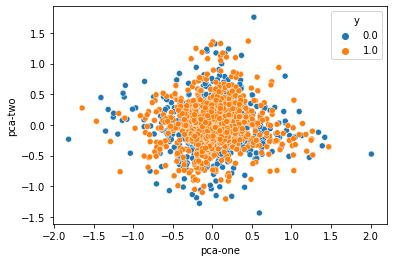

In [87]:
# Applying PCA to see how much we can gain from just 2 components

from sklearn.decomposition import PCA

# Only looking at energy
tmp_X = X_train[:, :, :, 0]
X = X_train.reshape(tmp_X.shape[0], -1)
pca = PCA(n_components=100)
pca.fit(X)
pca_result = pca.transform(X)

print(pca.explained_variance_ratio_)

df = pd.DataFrame({
    'pca-one':pca_result[:, 0], 
    'pca-two':pca_result[:, 1],
    'y':y_valid
})

sns.scatterplot(
    x='pca-one', y='pca-two',
    hue='y',
    data=df
)




In [71]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2048 samples in 0.577s...
[t-SNE] Computed neighbors for 2048 samples in 17.578s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2048
[t-SNE] Computed conditional probabilities for sample 2000 / 2048
[t-SNE] Computed conditional probabilities for sample 2048 / 2048
[t-SNE] Mean sigma: 0.572474
[t-SNE] KL divergence after 250 iterations with early exaggeration: 102.485786
[t-SNE] KL divergence after 300 iterations: 3.646333


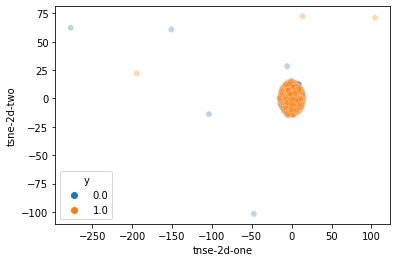

In [72]:
df['tnse-2d-one'] = tsne_results[:, 0]
df['tsne-2d-two'] = tsne_results[:, 1]

sns.scatterplot(
    x="tnse-2d-one", y="tsne-2d-two",
    hue="y",
    data=df,
    legend="full",
    alpha=0.3
)

In [ ]:
incorrects = np.nonzero(model.predict_classes(X_valid).reshape((-1,)) != y_valid)[0]

sample_number = incorrects[103]

# 100 looks like some kind of particle
plt.subplot(221)
plt.imshow(X_train[sample_number,:,:,0])
plt.title("Channel 0: Energy")  # Energy
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[sample_number,:,:,1])
plt.title("Channel 1: Time")  # Time
plt.grid(True)

plt.savefig(f'/home/n/Documents/Random/Coding/ML4SCI/ParticleImagesChallenge/images/test_images//{sample_number}')

In [92]:
# Transforming training data with pca
tmp_X = X_train[:, :, :, 0]
X_train_pca = X_train.reshape(tmp_X.shape[0], -1)
print(X_train_pca.shape)

(2048, 2048)


In [91]:
### Define Convolutional Neural Network (CNN) Model ###

model = Sequential()
model.add(Conv2D(16, activation='relu', kernel_size=1, padding='same', kernel_initializer='TruncatedNormal', input_shape=X_train_pca.shape))
model.add(Conv2D(16, activation='relu', kernel_size=1, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, activation='relu', kernel_size=1, padding='same', kernel_initializer='TruncatedNormal'))
model.add(Conv2D(32, activation='relu', kernel_size=1, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_initializer='TruncatedNormal'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_init), metrics=['accuracy'])
model.summary()

ValueError: Input 0 is incompatible with layer conv2d_2: expected ndim=4, found ndim=3

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-6)
history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)

## Evaluate the Model  
### Along with the model accuracy, the prefered metric for evaluation is ROC (Receiver Operating Characteristic) curve and the AUC score (Area under the ROC Curve).

In [79]:
# Evaluate on validation set
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

2048/2048 [==============================] - 1s 310us/step

Validation loss / accuracy: 0.6876 / 0.5840
Validation ROC AUC: 0.6194448471069336
2048/2048 [==============================] - 1s 305us/step

Test loss / accuracy: 0.6929 / 0.5835
Test ROC AUC: 0.6137580871582031


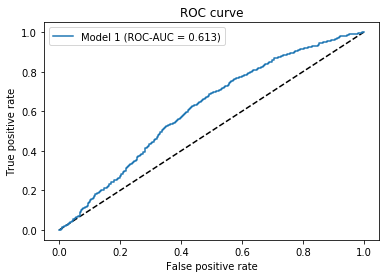

In [16]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Submission format: 
### Please submit the Google Colab Jupyter Notebook demonstrating your solution in the similar format as illustrated in this notebook. It should contain :
*   The final model architecture, parameters and hyper-parameters yielding the best possible performance,
*   Its Training and Validation accuracy, 
*   ROC curve and the AUC score as shown above.
*   Also, please submit the final trained model containing the model architecture and its trained weights along with this notebook (For example: HDF5 file, .pb file, .pt file, etc.). You are free to choose Machine Learning Framework of your choice. 